## Load Fashion-MNIST

In [125]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (_, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32')

(60000, 28, 28)
(10000, 28, 28)


## モデルの定義

In [147]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Sequential, layers


def quantize(x, min=0, max=255):
    scale = x / (tf.reduce_max(x) - 1e-8) * max
    min_max_normed = tf.clip_by_value(scale, min, max)
    return tf.cast(min_max_normed, tf.uint8)


class DummyMixin:

    def __init__(self):
        super().__init__()
        self.__dummy_original = None

    def dummy_encode(self, original):
        self.__dummy_original = original
        quantum = np.random.randint(0, 255, size=10, dtype=np.uint8)
        diff = np.random.randint(0, 255, size=[28, 28], dtype=np.uint8)
        return diff, quantum

    def dummy_decode(self, diff, quantum):
        return self.__dummy_original


class Autoencoder(DummyMixin, Model):

    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Sequential([
            layers.Flatten(),
            layers.BatchNormalization(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.BatchNormalization(),
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])

    def call(self, original):
        latent = self.encoder(original)
        recon = self.decoder(latent)
        return recon

    def encode(self, original, flatten=False):
        original = original.astype(np.uint8)
        latent = self.encoder(original.reshape(1, 28, 28))
        quantum = quantize(latent)
        recon = self.decoder.predict(quantum).astype(np.uint8)
        diff = original - recon
        if flatten:
            return diff.flatten(), quantum
        return diff, quantum

    def decode(self, diff, quantum):
        recon = self.decoder.predict(quantum)
        recon = recon.astype(np.uint8).reshape(28, 28)
        original = diff.reshape(28, 28).astype(np.uint8) + recon
        return original


autoencoder = Autoencoder(latent_dim=10)

## モデルの学習と保存

In [ ]:
tf.get_logger().setLevel('ERROR')

autoencoder.compile(optimizer='adam', loss="mean_squared_error", run_eagerly=True)
autoencoder.fit(x_train, x_train, epochs=5, shuffle=True, validation_data=(x_test, x_test))

In [150]:
from google.colab import drive
drive.mount('/content/drive')

autoencoder.save('autoencoder')

In [ ]:
!mkdir /content/drive/MyDrive/Colab\ Notebooks/autoencoder
!cp autoencoder /content/drive/MyDrive/Colab\ Notebooks/autoencoder

---

In [77]:
original_2 = np.hstack([(original * 255).flatten()]).astype(np.uint8)
diff = np.clip(diff * 255, 0, 255).flatten().astype(np.uint8)
concat = np.hstack([np.clip(diff * 255, 0, 255).flatten(), quantum.flatten()]).astype(np.uint8)

In [79]:
from scipy.stats import entropy

print(entropy(original_2))
print(entropy(diff))
print(entropy(concat))

4.9988986981277845
4.564602657140368
4.980737616990188


In [90]:
import carryless_rangecoder as rc
from io import BytesIO

img = diff
_, count = np.unique(np.hstack([img, np.arange(256)]), return_counts=True)
count_cum = count.cumsum().tolist()
count = count.tolist()

out = BytesIO()
# Encode
with rc.Encoder(out) as enc:  # or enc.finish()
    for pix in img.flatten().tolist():
        enc.encode(count, count_cum, pix)

print(len(out.getvalue()))
print(len(out.getvalue()) / 784 * 8)

208
2.122448979591837


diff(1L): 208  
concat as byte: 218  
concat on int: 220  

In [ ]:
from pathlib import Path as p
p("tmp").write_bytes(out.getvalue())

In [91]:
# out.getvalue() + bytes(quantum.flatten())
out.write(bytes(quantum.flatten()))

10

In [101]:
# Decode
decoded = []
with rc.Decoder(out) as dec:  # or dec.start()
    for _ in range(len(img) + 10):
        decoded.append(dec.decode(count, count_cum))
    
decoded = np.array(decoded)

In [102]:
decoded_img = decoded[:-10]
decoded_qu = decoded[-10:]

In [103]:
(diff == decoded_img).all()

True

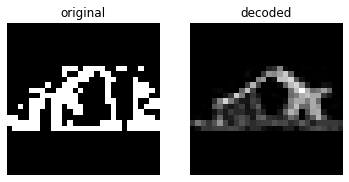

In [116]:
fig, axes = plt.subplots(1, 2)



axes[0].imshow(diff.reshape(28, 28) + recon, cmap="gray", vmin=0, vmax=1)
axes[0].set(title="original")

axes[1].imshow(original.reshape(28, 28), cmap="gray", vmin=0, vmax=1)
axes[1].set(title="decoded")

[ax.axis("off") for ax in axes]
plt.show()

In [110]:
(diff + recon.flatten() == original.flatten()).all()

False